# Estudio de Ascenso de Gradientes con una distribución normal

En este estudio vamos a utilizar una distribución normal.

In [ ]:
!git clone https://github.com/josesanchfez-umu/k_brazos_SFDD.git
# Instalar librerías
!pip install numpy seaborn pandas matplotlib scikit-learn

In [ ]:
import os
os.chdir('k_brazos_SFDD')
print("Directorio actual:", os.getcwd())

In [ ]:
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('./src')


# Verificar que se han añadido correctamente
print(sys.path)

In [ ]:
import numpy as np
from typing import List

from algorithms import Algorithm, Softmax, GradientBandit
from arms.armnormal import ArmNormal
from arms import Bandit
from plotting import plot_average_rewards, plot_regret

['C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml', '', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32\\lib', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\Pythonwin', './src/']


In [2]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                _, stats = arm_stats[idx]
                # Registrar selecciones y recompensas en arm_stats
                stats[chosen_arm][0] += 1  # Contador de selecciones
                stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    for _, stats in arm_stats:
        for arm in stats:
            selections, total_reward = stats[arm]
            stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated

## Softmax

Para este algoritmo, vamos a utilizar su parámetro τ, que controla el equilibrio entre exploración y explotación.
- Si τ es grande, todos los brazos tienen probabilidades similares para ser elegidos, lo que promueve la exploración.
- Si τ es pequeña, el brazo con mayor recompensa estimada se elige con mayor probabilidad, lo que prioriza la explotación.
- Si τ es 0, el algoritmo se comporta como un greedy puro, escogiendo siempre el mejor brazo estimado (pura explotación).

In [3]:

# Parámetros del experimento
seed = 42
# Fijar la semilla para reproducibilidad
np.random.seed(seed)  

# Número de brazos
k = 10 
# Número de pasos que se ejecutarán cada algoritmo
steps = 1000
# Número de ejecuciones  
runs = 500  

# Generar un bandido con k brazos de distribución Normal
bandit = Bandit(arms=ArmNormal.generate_arms(k)) 
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
softmax_algorithms = [Softmax(k=k, temperature=0.1), Softmax(k=k, temperature=0.5), Softmax(k=k, temperature=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
softmax_rewards, softmax_optimal_selections, softmax_arm_stats, softmax_regret_accumulated = run_experiment(bandit, softmax_algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Recompensa promedio

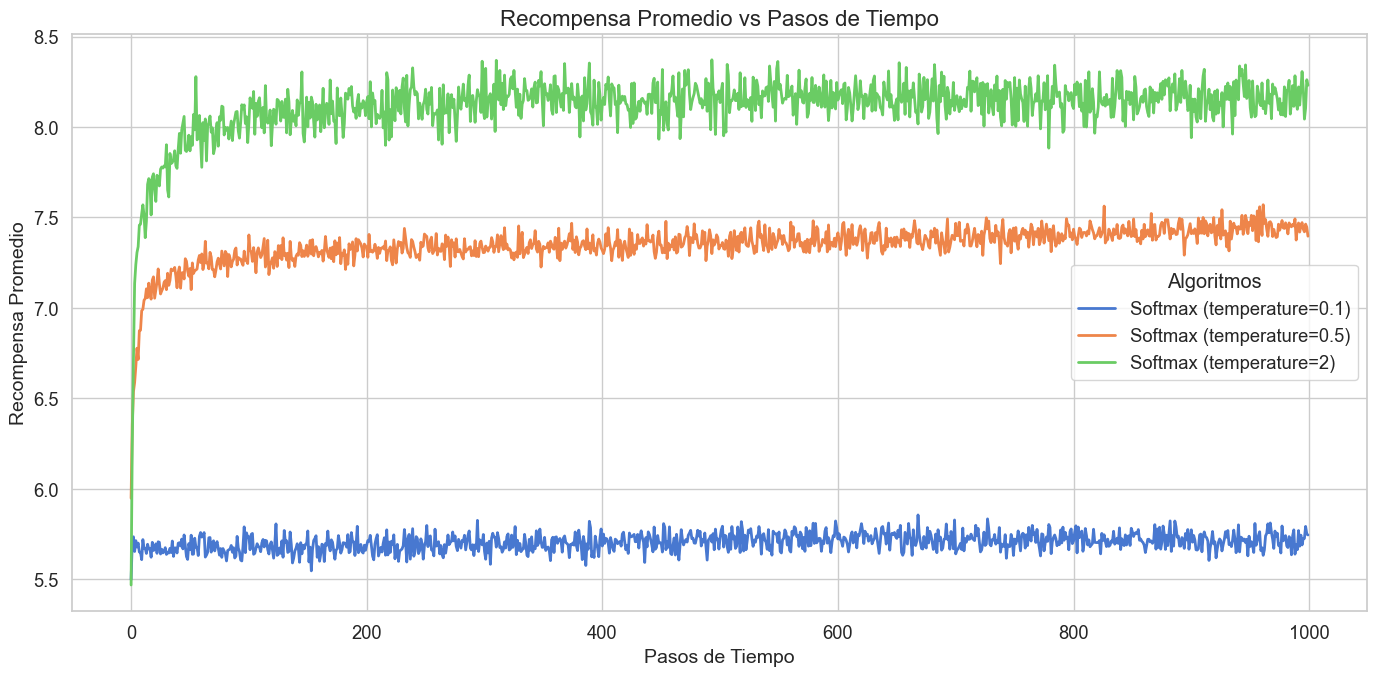

In [4]:
plot_average_rewards(steps, softmax_rewards, softmax_algorithms)

De primeras, podemos observar que, al igual que en la distribución de Bernoulli, hay algo de ruido.

- **Softmax (temperature=0.1):** tiene, con diferencia, la peor recompensa promedio, estando estabilizada desde el principio. Al tener una temperatura tan baja, limita mucho la exploración, favoreciendo casi exclusivamente las acciones con recompensas iniciales percibidas como mejores. Esto lleva a una explotación prematura y subóptima.
- **Softmax (temperature=0.5):** la recompensa promedio que obtiene es algo moderada, estabilizándose en los pasos iniciales alrededor de 7.5. Este valor para la temperatura hace que haya cierto equilibrio entre exploración y explotación, sin embargo, este equilibrio con una distribución normal puede ser menos efectivo.
- **Softmax (temperature=2):** presenta la mejor recompensa promedio, estabilizándose cerca de 8.5 después de una fase de exploración debido al valor elevado de la temperatura. En un caso con una distribución normal de recompensas, esta exploración robusta es parece ser ventajosa porque ayuda a identificar y explotar las regiones más lucrativas.

El valor de temperatura controla cómo el Softmax balancea exploración y explotación. Al igual que en la distribución binomial, vemos que un enfoque más exploratorio resulta más exitoso a la hora de encontrar acciones con mayores recompensas.

### Rechazo acumulado

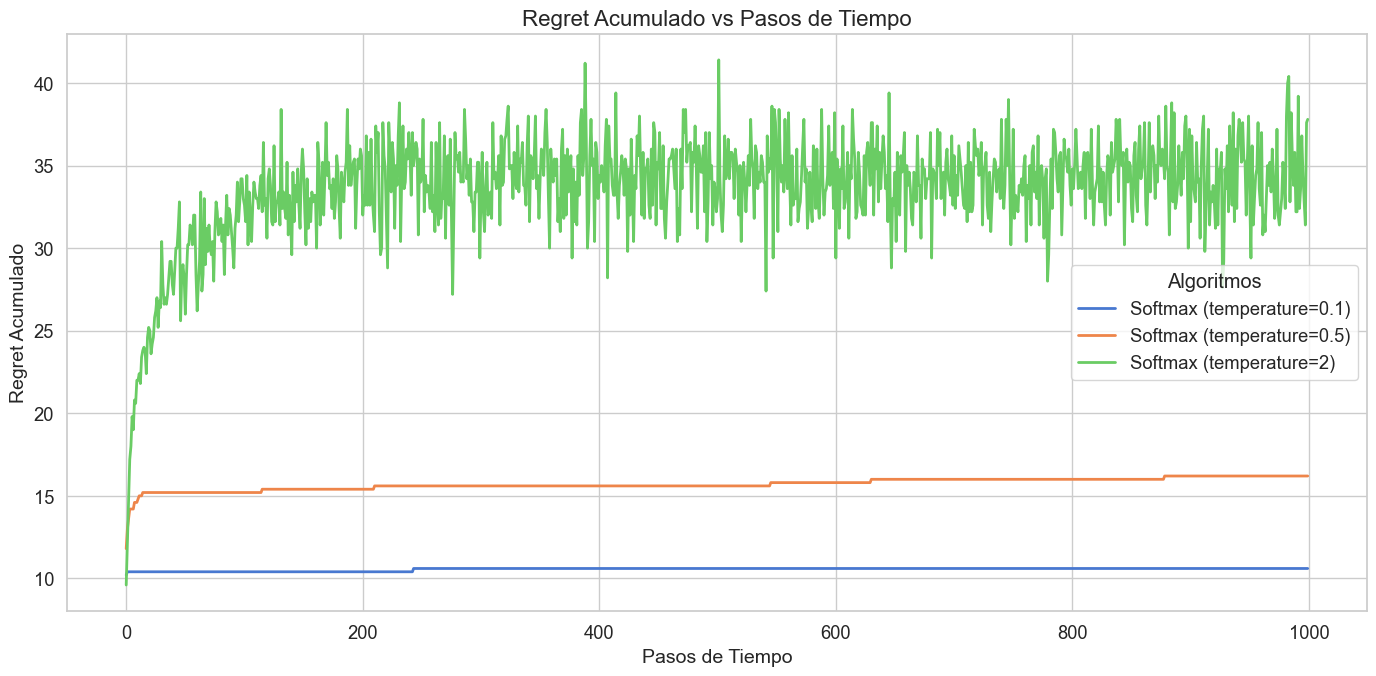

In [8]:
plot_regret(steps, softmax_optimal_selections, softmax_algorithms)

- **Softmax (temperature=0.1):** presenta el menor rechazo acumulado, estabilizándose en valores superiores a 10. De nuevo, la baja temperatura hace que el algoritmo tenga una exploración muy limitada, escogiendo siempre el mismo brazo.
- **Softmax (temperature=0.5):** al igual que en la recompensa promedio, el rechazo acumulado es moderado, quedando en medio de los algoritmos, gracias a ese equilibro entre exploración y explotación.
- **Softmax (temperature=2):** tiene el rechazo acumulado más alto, con muchas fluctuaciones. Al promover una alta exploración, inicalmente consigue acumular mucho rechazo, ya que tarda más tiempo en identificar las mejores opciones. Esto puede ser ventajoso a largo plazo en entornos complejos, pero aquí se traduce en un rechazo acumulado elevado.

## Gradiente de preferencias

Para este algoritmo se utiliza α como parámetro, que es el paso de actualización del gradiente y controla la tasa de aprendizaje del algoritmo
- Si α es pequeña, el aprendizaje del algoritmo será más lento pero más estable.
- Si α es grande, el aprendizaje será más rápido, pudiendo producirse oscilaciones o inestabilidad.

In [9]:
# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
gradient_algorithms = [GradientBandit(k=k, alpha=0.01), GradientBandit(k=k, alpha=0.1), GradientBandit(k=k, alpha=0.5)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
gradient_rewards, gradient_optimal_selections, gradient_arm_stats, gradient_regret_accumulated = run_experiment(bandit, gradient_algorithms, steps, runs)

### Recompensa promedio

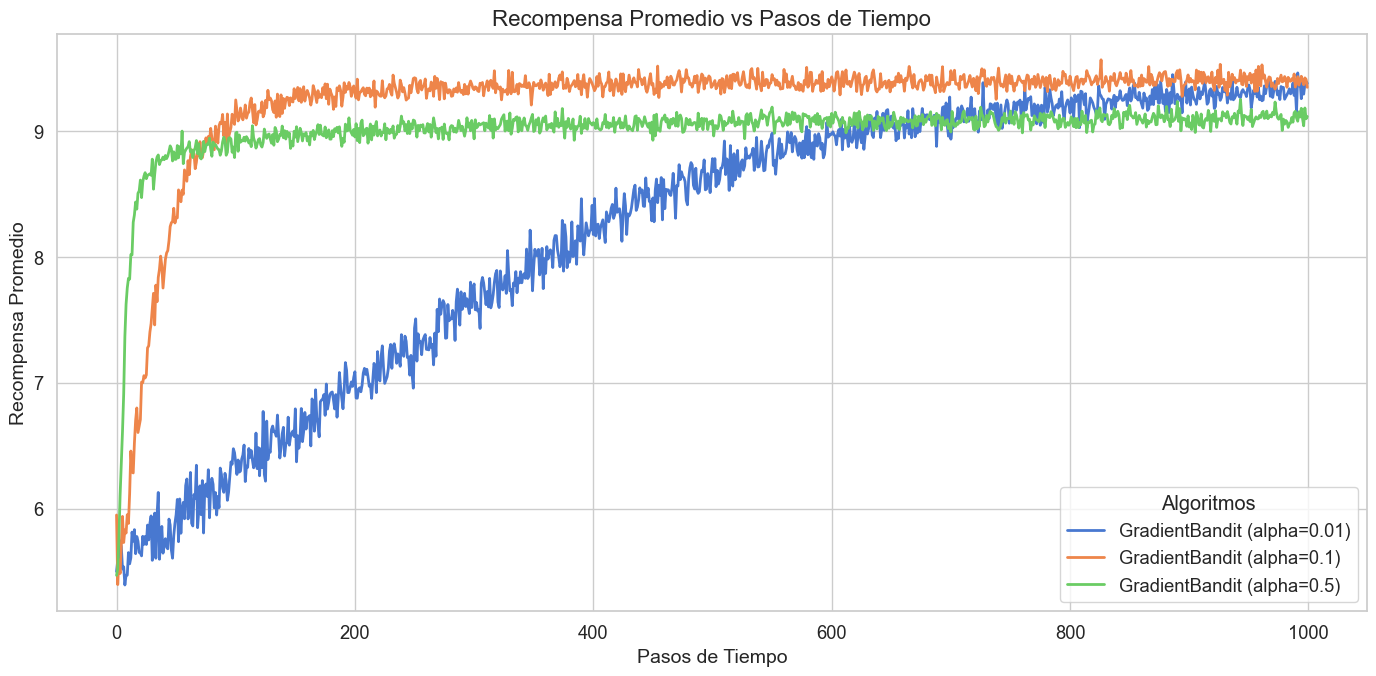

In [10]:
plot_average_rewards(steps, gradient_rewards, gradient_algorithms)

- **GradientBandit (alpha=0.01):** vemos como, al igual que en el resto de experimentos, un valor muy bajo para la tasa de aprendizaje se traduce en una recompensa promedio inicial muy baja, pero va creciendo de forma constante hasta estabilizarse, incluso superando un algoritmo con una tasa de aprendizaje bastante superior.
- **GradientBandit (alpha=0.1):** este algoritmo logra alcanzar rápidamente la recompensa promedio más alta y mantenerla. Su estabilidad la convierte en la mejor opción para maximizar el aprendizaje sin incurrir en inestabilidad, consiguiendo un equilibrio entre exploración y explotación.
- **GradientBandit (alpha=0.5):** aunque es el algoritmo que crece más rápido en este aspecto, en las etapas finales es el que peor recompensa promedio consigue de los tres, con un valor para alpha que hace que su aprendizaje sea más agresivo.

En un caso donde las recompensas tienen una distribución normal, las configuraciones con valores intermedios de α (0.1) son mejores, ya que permiten adaptarse con rapidez y estabilidad. Por el contrario, configuraciones extremadamente conservadoras (α = 0.01) o agresivas (α = 0.5) pueden presentar limitaciones en términos de velocidad de aprendizaje o estabilidad respectivamente.

### Rechazo acumulado

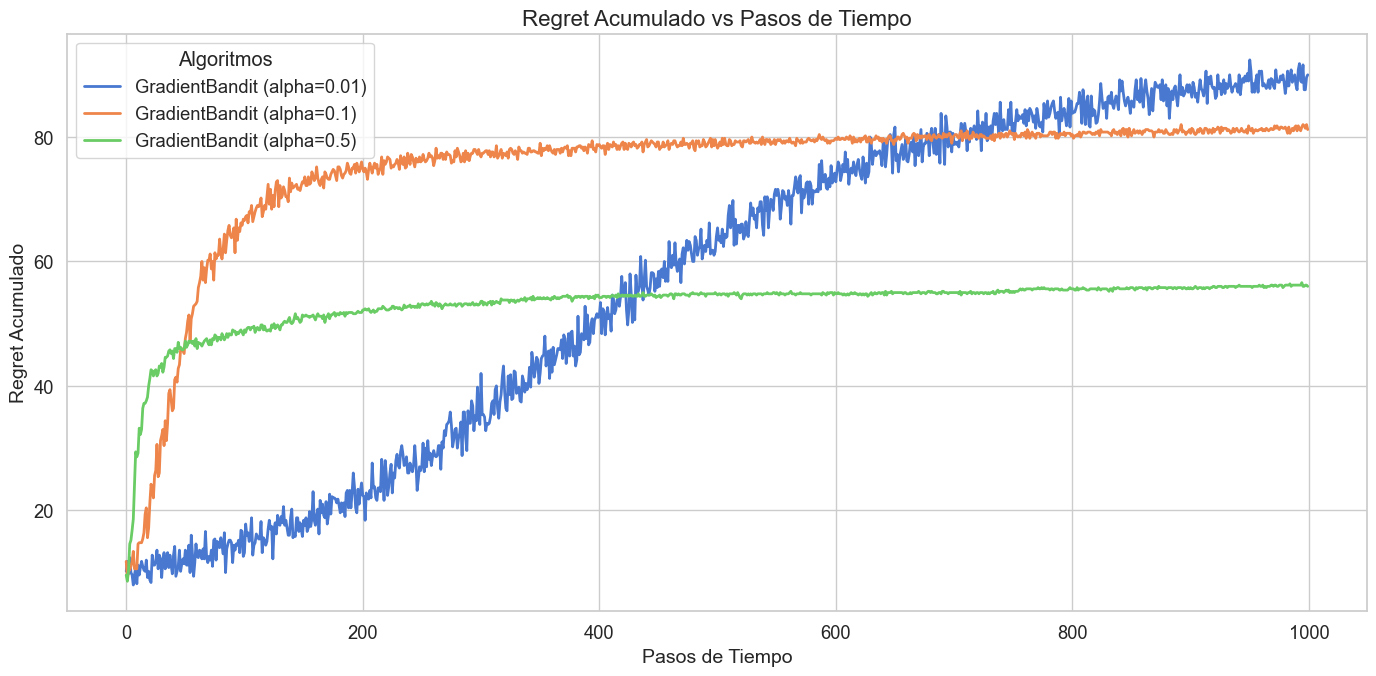

In [12]:
plot_regret(steps, gradient_optimal_selections, gradient_algorithms)

Vemos como la forma de la gráfica es muy parecida a la que obtenemos en el experimento de la distribución binomial.

- **GradientBandit (alpha=0.01):** refleja un incremento constante, debido a que la tasa de aprendizaje es demasiado baja y tarda mucho más en identificar las mejores acciones.
- **GradientBandit (alpha=0.1):** logra un buen balance, con una curva que se eleva en el inicio, pero se estabiliza rápidamente, logrando un rechazo incluso menor que el algoritmo con la tasa más conservadora. Indica una capacidad para encontrar acciones óptimas con exploración suficiente sin sobreajuste.
- **GradientBandit (alpha=0.5):** muestra un rechazo acumulado elevado inicialmente debido a una exploración agresiva, aunque logra estabilizarse en un nivel intermedio. Esto demuestra una velocidad de aprendizaje alta, aunque algo reactiva en entornos con mayor variabilidad.

## Softmax vs Gradiente de preferencias

En este apartado vamos a comparar ambos algoritmos.

### Recompensa promedio y rechazo acumulado

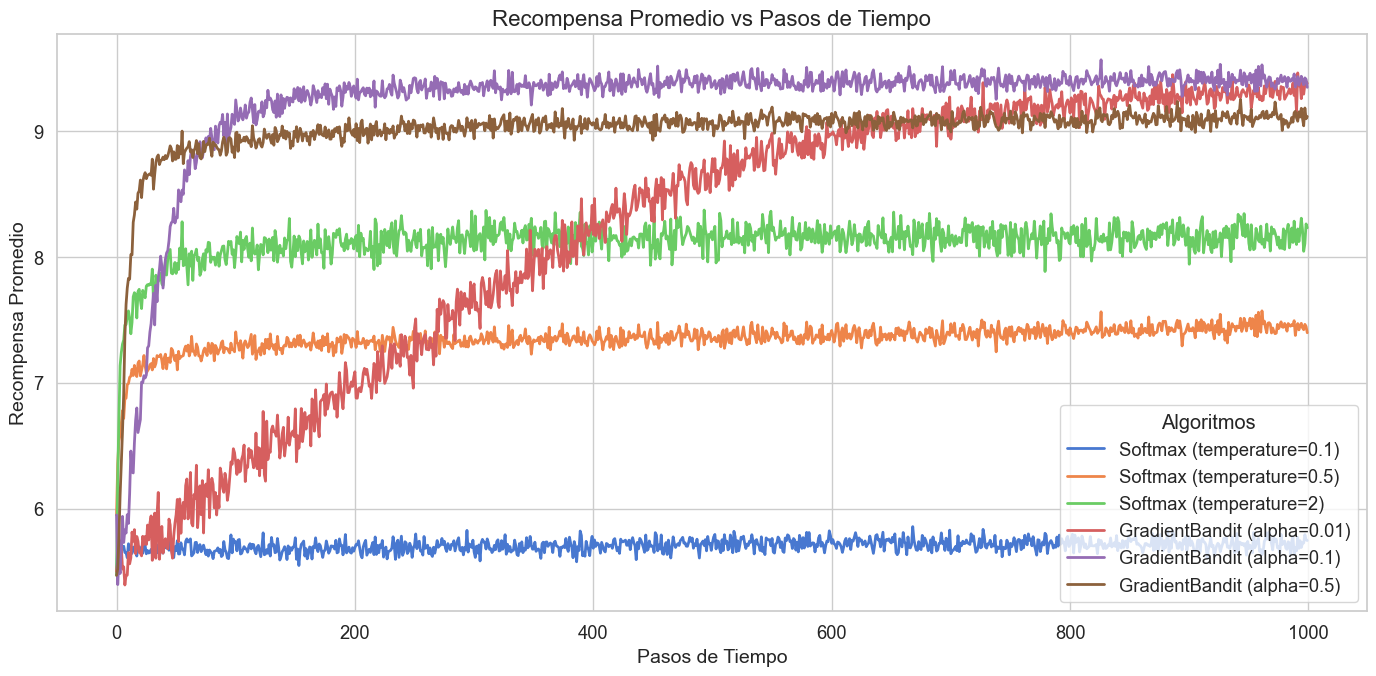

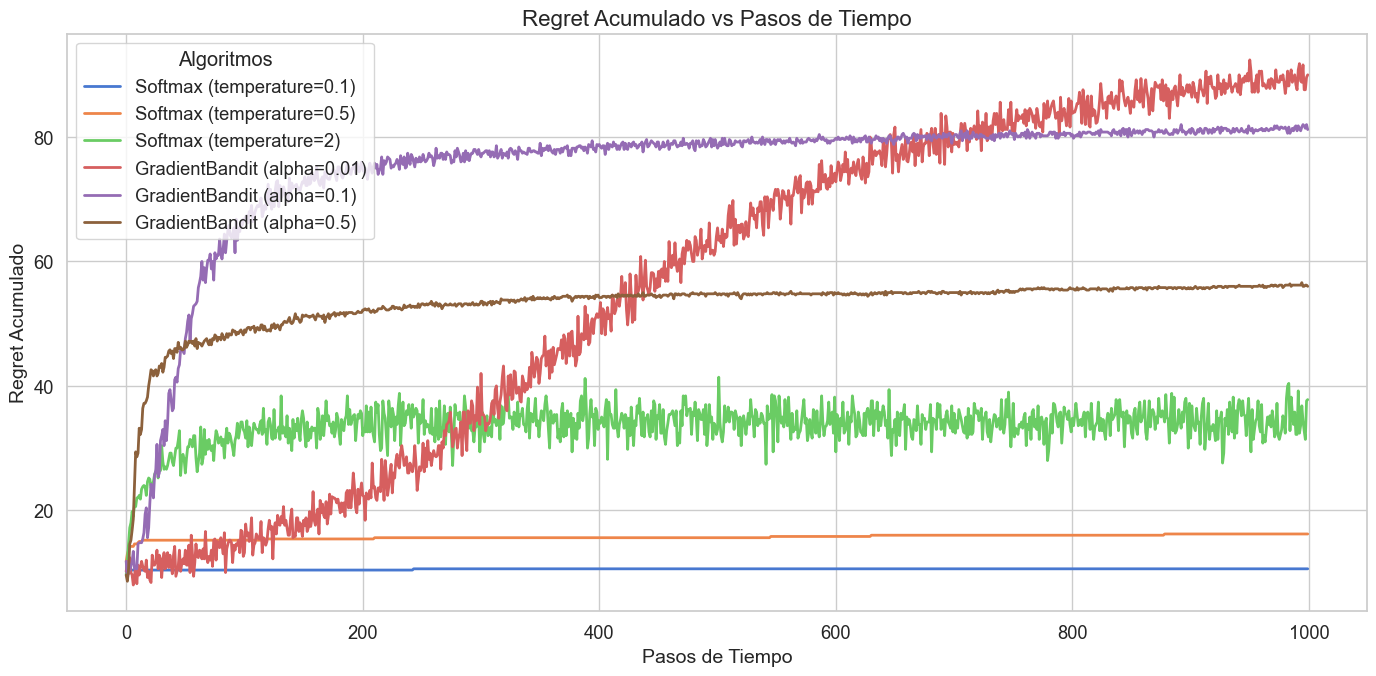

In [14]:
plot_average_rewards(steps, np.vstack((softmax_rewards, gradient_rewards)), softmax_algorithms+gradient_algorithms)
plot_regret(steps, np.vstack((softmax_optimal_selections, gradient_optimal_selections)), softmax_algorithms+gradient_algorithms)

En conjunto, combinando el análisis de recompensa promedio y rechazo acumulado, el algoritmo GradientBandit con αºalpha = 0.1 destaca como la mejor configuración. Este logra un equilibrio ideal al alcanzar una alta recompensa promedio y mantener un rechazo acumulado moderado, mostrando estabilidad y adaptabilidad frente a una distribución normal de recompensas.

El GradientBandit con alpha = 0.5, aunque logra la mejor recompensa promedio, tiene un rechazo acumulado más alto, lo que indica que un aprendizaje agresivo puede ser beneficioso en ciertos casos, pero introduce inestabilidad. Por otro lado, el GradientBandit con alpha = 0.01 tiene un peor desempeño en general, con un progreso lento hacia recompensas altas y un rechazo acumulado elevado debido a su excesiva cautela.

En cuanto a Softmax, en general los resultados son peores. La configuración con una temperatura de 2 explora extensamente y logra una recompensa promedio decente, pero con el costo de un rechazo acumulado elevado. Las configuraciones con una temperatura de 0.5 y 0.1, como son más conservadoras, no logran explorar lo suficiente y, por lo tanto, tienen un peor desempeño en términos de recompensa promedio, aunque presentan un menor rechazo acumulado.